In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from scipy.sparse import csr_matrix as sparse_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD

# Load the functions
import sys
sys.path.insert(1, '../src')
from preprocessing_eda import *

## Read the training data and do some EDA

In [2]:
df_train = pd.read_csv("../data/clean/df_train.csv", index_col=0)

In [3]:
df_train.head()

,UserId,ProductId,Rating,Timestamp
691810,A2O5EXPH8UKUS3,B001FSK8PS,5.0,1372204800
515687,A3I64V4AR136KY,B00121UVU0,1.0,1352246400
366115,A2N56YII67PSHS,B000P20RQU,5.0,1359072000
571174,A3RV5ZUA8W67FK,B0016P4P4K,5.0,1350432000
1664068,A2XRZV63X79YSJ,B008EKY8VK,4.0,1378252800


We need to transfer the `Timestamp` to more readable format.

In [4]:
df_train['Timestamp'] = df_train['Timestamp'].apply(datetime.fromtimestamp)

In [5]:
df_train.head()

,UserId,ProductId,Rating,Timestamp
691810,A2O5EXPH8UKUS3,B001FSK8PS,5.0,2013-06-25 17:00:00
515687,A3I64V4AR136KY,B00121UVU0,1.0,2012-11-06 16:00:00
366115,A2N56YII67PSHS,B000P20RQU,5.0,2013-01-24 16:00:00
571174,A3RV5ZUA8W67FK,B0016P4P4K,5.0,2012-10-16 17:00:00
1664068,A2XRZV63X79YSJ,B008EKY8VK,4.0,2013-09-03 17:00:00


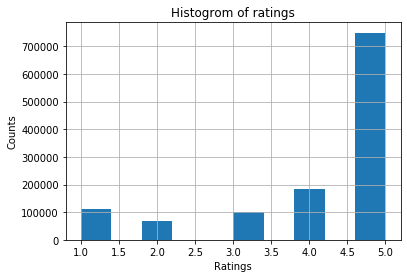

In [6]:
df_train['Rating'].hist()
plt.xlabel("Ratings")
plt.ylabel("Counts")
plt.title("Histogrom of ratings");

In [7]:
num_users = len(set(df_train['UserId']))
num_products = len(set(df_train['ProductId']))
print("Number of ratings:", len(df_train))
print("The average rating:", round(np.mean(df_train["Rating"]),2))
print("Number of users:", num_users)
print("Number of items:", num_products)
print("Fraction nonzero:", len(df_train)/(num_users*num_products))
print("Size of full X matrix (GB):", round((num_users*num_products)*8/1e9, 2))

Number of ratings: 1213842
The average rating: 4.15
Number of users: 821976
Number of items: 199393
Fraction nonzero: 7.4061604321739915e-06
Size of full X matrix (GB): 1311.17


If a full utility matrix is built, it would to too large (1311 GB). On the other hand, we have only 1.2 million ratings, which should be only around 10 MB. Hence, we need to use the sparse matrix for the matrix.

In [8]:
X, user_mapper, item_mapper, user_inverse_mapper, item_inverse_mapper, user_ind, item_ind = create_X(df_train, n=num_products, d=num_users, user_key='UserId', item_key='ProductId')

In [9]:
# sanity check
print(X.shape) # should be number of items by number of users
print(X.nnz)   # number of nonzero elements -- should equal number of ratings
print(f"Using sparse matrix data structure, the size of X is: {round(X.data.nbytes/1e6,2)}MB")

(199393, 821976)
1213842
Using sparse matrix data structure, the size of X is: 9.71MB


In [10]:
# Get the required IDs
item_id_most_reviews, item_id_most_total, item_id_lowest_avg = get_id(X, item_inverse_mapper)

In [11]:
# Print the results
print("The item with the most reviews is:")
display(HTML('<a href="%s">%s</a>' % ('https://www.amazon.com/dp/' + item_id_most_reviews, 
                                      item_id_most_reviews)))

print("The item with the most total stars is:")
display(HTML('<a href="%s">%s</a>' % ('https://www.amazon.com/dp/' + item_id_most_total, 
                                      item_id_most_total)))

print("The item with the lowest average stars is:")
display(HTML('<a href="%s">%s</a>' % ('https://www.amazon.com/dp/' + item_id_lowest_avg, 
                                  item_id_lowest_avg)))

The item with the most reviews is:


The item with the most total stars is:


The item with the lowest average stars is:


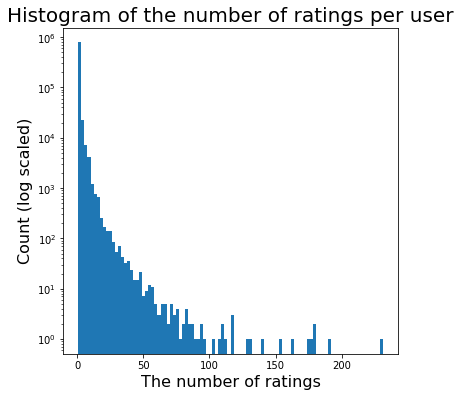

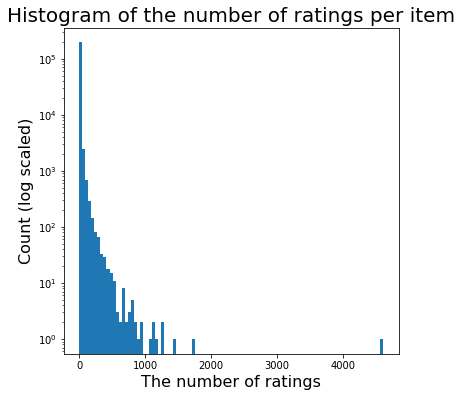

In [12]:
plot_hist(X)

In [13]:
# Proportion of users rating less than 3 items
np.sum(X.getnnz(axis=0) < 3)/X.shape[1]

0.911364808704877

In [14]:
# Proportion of items receiving less than 12 ratings
np.sum(X.getnnz(axis=1) < 12)/X.shape[0]

0.901791938533449

> 1. Most users give ratings only for one or two items and most items receive less than 20 ratings.
> 2. After log scaled, both the number of ratings per user and per item look like the exponential distribution.

## Find the similar products to the most reviewed product: B001MA0QY2

In [15]:
most_reviewed = "B001MA0QY2"
most_reviewed_ind = item_mapper[most_reviewed]
most_reviewed_vec = X[most_reviewed_ind]

In [16]:
# Using Euclidean distance
neighbors_ind = fit_nn(X, most_reviewed_vec, 7)
print_result(neighbors_ind, item_inverse_mapper)

The 6 items most similar to the most reviewed product (exclusive) are:


In [17]:
# Using cosine similarity
neighbors_cos_ind = fit_nn(X, most_reviewed_vec, 7, 'cosine')
print_result(neighbors_cos_ind, item_inverse_mapper)

The 6 items most similar to the most reviewed product (exclusive) are:


In [18]:
# Use Euclidean distance
cal_total_popularity(X, neighbors_ind, item_inverse_mapper)

The total popularity:


Total stars: 19843


Total stars: 5


Total stars: 5


Total stars: 5


Total stars: 5


Total stars: 5


Total stars: 5


In [19]:
# Use Cosine similarity
cal_total_popularity(X, neighbors_cos_ind, item_inverse_mapper)

The total popularity:


Total stars: 19843


Total stars: 2527


Total stars: 266


Total stars: 5


Total stars: 5


Total stars: 5


Total stars: 5
